# Sentiment140 preprocessing and feature extraction

In [1]:
%matplotlib inline

import dask
import dask.dataframe
import dask.diagnostics
import dask.multiprocessing
import langid
import os
import pandas as pd
import matplotlib
from urllib.request import urlretrieve
import spacy
import ssl
import sys
from zipfile import ZipFile
from tqdm import tqdm

matplotlib.rcParams.update({
    'figure.figsize': (20, 9),
    'font.size': 18,
    'grid.color': 'k',
    'grid.linestyle': ':',
    'grid.linewidth': 0.5,
    'lines.linewidth': 3
})

LOCAL_PATH = '../data/sentiment140'
PATH_TO_ARCHIVE = os.path.join(LOCAL_PATH, 'archive.zip')

os.makedirs(LOCAL_PATH, exist_ok=True)

## Download archive

In [2]:
with tqdm() as progress:
    def report(count, blockSize, totalSize):
        progress.total = totalSize
        progress.update(blockSize)
    ssl._create_default_https_context = ssl._create_unverified_context
    urlretrieve('http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip',
                PATH_TO_ARCHIVE, reporthook=report)

81379328it [00:34, 2362472.59it/s]                              


## Extract and tidy data

In [3]:
with ZipFile(PATH_TO_ARCHIVE) as zip_file:
    df = pd.read_csv(zip_file.open('training.1600000.processed.noemoticon.csv'),
                    encoding='latin1', names=['target', 'id', 'date', 'flag', 'user', 'tweet'])

df['sentiment'] = df['target'].map({0: 'negative',
                                    2: 'neutral',
                                    4: 'positive'})

df = df[['sentiment', 'user', 'tweet']]

## Remove tweets by robots

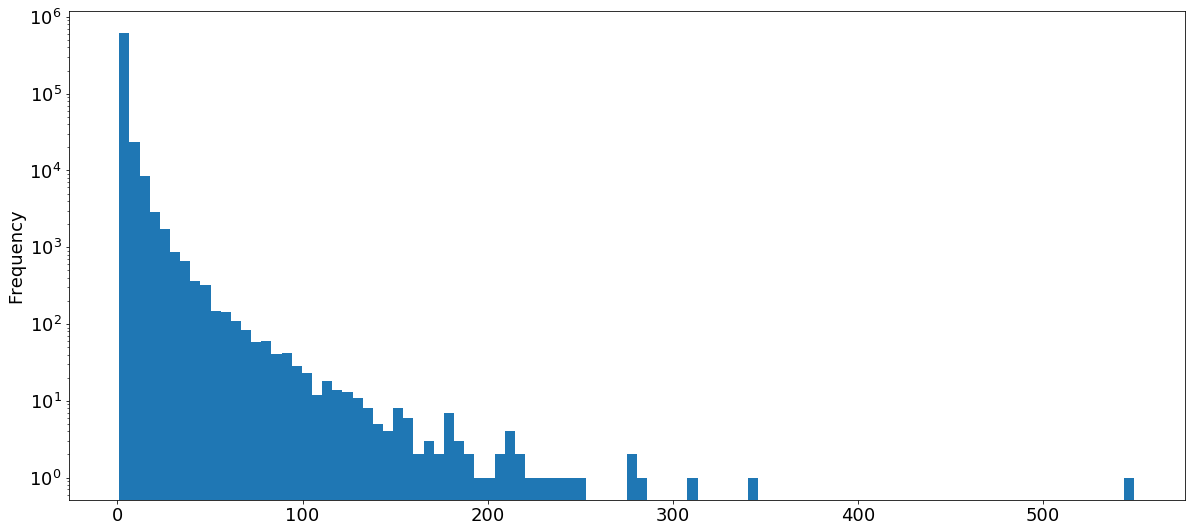

In [4]:
tweets_per_user = df.groupby('user')['tweet'].count()
tweets_per_user.plot.hist(log=True, bins=100)

In [5]:
tweets_per_user[tweets_per_user > 200].sort_values(ascending=False)

user
lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
mcraddictal        276
tsarnick           248
what_bugs_u        246
Karen230683        238
DarkPiano          236
SongoftheOss       227
Jayme1988          225
keza34             219
ramdomthoughts     216
shanajaca          213
wowlew             212
nuttychris         211
TraceyHewins       211
thisgoeshere       207
Spidersamm         205
StDAY              202
Name: tweet, dtype: int64

In [6]:
df[df['user'] == 'lost_dog']['tweet'].sample(10)

69350     @LadyHilary I am lost. Please help me find a g...
55096     @adevenish I am lost. Please help me find a go...
165655    @seth_cohen I am lost. Please help me find a g...
284455    @ValenciaBlog I am lost. Please help me find a...
627166    @pearlgirl I am lost. Please help me find a go...
517151    @lkl I am lost. Please help me find a good home. 
772993    @kgtv I am lost. Please help me find a good ho...
610551    @exmouthjournal I am lost. Please help me find...
743982    @fannyrust I am lost. Please help me find a go...
269948    @blueskyrei I am lost. Please help me find a g...
Name: tweet, dtype: object

In [7]:
df[df['user'] == 'webwoke']['tweet'].sample(10)

428956     damn... drop by 14  63. webhostingtalk.com
366601               auchh, drop by 1  (20)reddit.com
380218       ohh s**t... drop by 2  97. mybloglog.com
416753         damn... drop by 1  46. blogtoplist.com
423880       aughh... drop by 1  68. prankoffate.info
443471          holys**t drop by 1  23. slideboom.com
408365             F**K! drop by 2  80. seolithic.com
384954        owww god, drop by 1  91. yehiapress.org
452801           damn... drop by 8  84. seolithic.com
443541    damn... drop by 1  27. 1888pressrelease.com
Name: tweet, dtype: object

In [8]:
df[df['user'] == 'tweetpet']['tweet'].sample(20)

47315                      @wtfwouldericado  Clean Me!
46516                            @NBAgrl914  Clean Me!
40576                           @jessicas55  Clean Me!
46471                             @SRBMALIK  Clean Me!
46486                            @aubinerie  Clean Me!
46469                               @eDTGCa  Clean Me!
43239                               @QeJP2B  Clean Me!
43181                          @blacksmoke3  Clean Me!
39761                               @jimhat  Clean Me!
40545                           @tweetchild  Clean Me!
43229                          @Noprisoners  Clean Me!
46511                        @Kathrynsweets  Clean Me!
43170                          @Mzcertified  Clean Me!
47303                           @jessicas55  Clean Me!
46482                          @blacksmoke3  Clean Me!
31976                          @bjwheeler_2  Clean Me!
27011                           @pcnlove125  Clean Me!
43222                              @1luv633  Clean Me!
47308     

In [9]:
df[df['user'] == 'SallytheShizzle']['tweet'].sample(20)

1042168    @ddlovato if I sent you a twitpic link would y...
648530     I have to TIP the cd onto itunes cause it's no...
1217051                      @LuckyUrWithAmy i got this one 
508591     @OfficialAS haha suuuuure... i mena I'm happy ...
345296     @hot30 http://twitpic.com/6glx9 - I want Andre...
688394     I'm hungry. GAAAAAAAAH. No freaking dinner ......
1324744    @MAGGIECHICKEN meh same diff. Just still with ...
739291     @jonasbrothers so in 12 days time... you boys ...
1330279    @OfficialAS just cry then  let the emotion out...
428309     @OfficialAS http://twitpic.com/6tn2j - oooh st...
227176     @OfficialAS haha yeah... but i need it to get ...
1153573    @OfficialAS nawww  ily!!   i have a class tomo...
238683     @angelapanagacos you...but...but...   naaaaaaa...
1524116    @OfficialAS and if people DONT remember...they...
141880     @angelapanagacos shit what about adge?!! WE CA...
432507                               barking dogs... AGAIN! 
776320     @MariaBernal 

In [4]:
df = df[~df.user.isin(['lost_dog', 'webwoke', 'tweetpet'])]

## Filter non-English tweets

In [5]:
dd = dask.dataframe.from_pandas(df, npartitions=100)
with dask.diagnostics.ProgressBar():
    df['langid'] = dd.map_partitions(
        lambda dataframe: dataframe.apply(
            (lambda row: langid.classify(row['tweet'])[0]), axis=1)) \
        .compute(get=dask.multiprocessing.get)

df = df[df['langid'] == 'en'].reindex()

[########################################] | 100% Completed | 11min  6.6s


## Process with spaCy

In [6]:
nlp = spacy.load('en_core_web_lg')

In [7]:
docs = list(nlp.pipe(df['tweet'], disable=['parser', 'ner']))

In [9]:
def get_features(doc):
    features = list()
    for token in doc:
        if token.lemma_.startswith('@'):
            features.append(('__HANDLE__', 'PROPN'))
        elif 'http' in token.lemma_ or 'www' in token.lemma_:
            features.append(('__URL__', '__URL__'))
        else:
            features.append((token.lemma_, token.tag_))
    return features
    
df['features'] = [get_features(doc) for doc in docs]

In [20]:
df.index.rename('identifier', inplace=True)
df.to_csv(os.path.join(LOCAL_PATH, 'tokens.csv'))

In [11]:
df.to_hdf(os.path.join(LOCAL_PATH, 'sentiment140.h5'), 'Sentiment140')

/Users/jonathon.read/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['sentiment', 'user', 'tweet', 'langid', 'features']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
